In [172]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, paired_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer


## Project Topic
Clustering Supporting Players on NBA championship teams based upon draft combine statistics and rookie season performance. Using Kmeans supervised learning. 

There are 30 teams in the National Basketball Association, and each year a Championship team is crowned. The Champion is determined by the best 16 teams playing a bracketed tournament, this is called the NBA playoffs. Each team features about 12-15 players. Typically, there are about 7-9 players that contribute significantly to their respective teams. Usually there are one or two “star” players that carry the burden offensively. The rest of the players that contribute are filled out with players whose skill set is more supportive. In common basketball nomenclature, these players are referred to as “role players”.

Each year the NBA holds a “Draft Combine” where prospective players participate in measurements of their physical attributes and athletic abilities. Height, arm length, body fat percentage, sprinting speed, bench press repetitions at 225lbs are just some of the measured attributes.

I am writing an unsupervised machine learning model that will attempt to cluster role players on NBA championship winning teams based upon their statistical performance in the NBA playoffs. I will then take these clusters, and extend them to the entirety of the draft combine, using the data from the combine, as well as statistics from the players first season in the NBA. This will serve as a prediction of the type of player prospective NBA players could develop into. 


## Data
I pulled data from several different sources:
1. First is a list of all seasons NBA players have played. I used this data to select players first seasons: https://www.kaggle.com/datasets/justinas/nba-players-data
2. Next is a data set of playoff statistics from 1950-2022. This was used to collect playoff stats for championship winning teams. I simply filtered to only the winning teams: https://www.kaggle.com/datasets/robertsunderhaft/nba-playoffs
3. Last we have the draft combine data: https://www.kaggle.com/datasets/wyattowalsh/basketball/data

We only have draft combine data from 2000-present, so I only clustered players that won championships from 2001-2022 which is the end of the data for playoff stats that I have.

For creating the clusters, we have 18 numeric features. Some of these are simple counting statistics, evaluated on a per game basis, such as points, rebounds, blocks or steals per game. Others represent efficiency statistics such as shooting percentage (the ratio of shots made per shots attempted). We also have statistics that measure individual impact on team performance, such as offensive and defensive box plus minus. These numbers represent a difference in efficiency per 100 possessions. For example if the Chicago Bulls average 100 points per 100 possessions overall, and 101 points per 100 possessions when Michael Jordan is playing, Jordan would have an offensive plus minus of 1. Defensive box plus minus would refer to the difference in opponents' scoring percentage while a player is playing. Finally we have win shares, offensive, defensive and combined. Win shares represent points produced or saved by the player, normalized against league averages. I also added a column of my own to the statistics, which is the percentage of games started. Teams typically have more players than can play at once, so some players have to wait to play. Generally teams begin with their strongest players in the game.

Below we have paths to our csv files, and a list of tuples of NBA champions.

In [173]:
all_seasons_file = 'all_seasons.csv'
playoff_stats_file = 'playoffStats.csv'
draft_combine_file = 'draft_combine_stats.csv'


nba_champions = [
    ('2001', 'LAL'),
    ('2002', 'LAL'),
    ('2003', 'SAS'),
    ('2004', 'DET'),
    ('2005', 'SAS'),
    ('2006', 'MIA'),
    ('2007', 'SAS'),
    ('2008', 'BOS'),
    ('2009', 'LAL'),
    ('2010', 'LAL'),
    ('2011', 'DAL'),
    ('2012', 'MIA'),
    ('2013', 'MIA'),
    ('2014', 'SAS'),
    ('2015', 'GSW'),
    ('2016', 'CLE'),
    ('2017', 'GSW'),
    ('2018', 'GSW'),
    ('2019', 'TOR'),
    ('2020', 'LAL'),
    ('2021', 'MIL'),
    ('2022', 'GSW')
]

valid_teams_years_set = set(nba_champions)

features_playoff = [
    "pts_per_g",
    "fga_per_g",
    "trb_per_g",
    "dbpm",
    "obpm",
    'per',
    'ws',
    'ows',
    'usg_pct',
    'ts_pct',
    'pct_gs',
    'dws',
    'trb_pct',
    'fg3a_per_fga_pct',
    'mp_per_g',
    'ast_pct',
    'stl_per_g',
    'blk_per_g',
]

keep = [
    'player_height',
    'player_weight',
    'wingspan',
    'standing_reach',
    'body_fat_pct',
    'standing_vertical_leap',
    "max_vertical_leap",
    'lane_agility_time',
    'three_quarter_sprint',
    'bench_press',
    'gp',
    'pts',
    'reb',
    'net_rating',
    'oreb_pct',
    'dreb_pct',
    'usg_pct',
    'ts_pct',
    'ast_pct',
]



In [174]:
def load_data(file_path):
    return pd.read_csv(file_path)

lets load and inspect the player seasons data.

We have 12844 rows of data and 22 columns. This represents over 12000 player seasons, and about 20 statiscial categories. 

In [175]:
seasons_df = load_data(all_seasons_file)

print(seasons_df.shape)

seasons_df.head()

(12844, 22)


,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


Now lets look at the playoff stats data.
We will also conver the season field to a string.

Here we have 10648 player seasons, and 51 columns.

In [176]:
stats_df = load_data(playoff_stats_file)

stats_df['season'] = stats_df['season'].astype(str)

print(stats_df.shape)

stats_df.head()

(10648, 51)


,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ows,per,stl_pct,tov_pct,trb_pct,ts_pct,usg_pct,vorp,ws,ws_per_48
0,2022,Omer Yurtseven,C,23,MIA,9,0.0,4.2,1.3,2.0,...,0.1,25.8,0.0,0.0,10.8,0.647,22.6,0.1,0.2,0.228
1,2022,Kessler Edwards,SF,21,BRK,2,0.0,3.5,0.0,0.0,...,0.0,-2.2,7.3,100.0,0.0,NaN,6.6,0.0,0.0,-0.104
2,2022,Draymond Green,PF,31,GSW,22,22.0,32.0,3.1,6.5,...,0.4,12.3,1.8,26.4,12.7,0.534,14.0,0.5,1.4,0.094
3,2022,Danny Green,SF,34,PHI,12,12.0,26.6,3.0,7.4,...,0.0,9.9,2.0,12.7,7.1,0.576,15.1,0.3,0.3,0.049
4,2022,Devonte' Graham,PG,26,NOP,6,0.0,10.0,1.0,3.0,...,0.1,11.5,0.9,15.7,8.9,0.558,18.3,0.0,0.1,0.049


Now let's load the data from the draft combine, and inspect it as well.

We have 1202 rows of players and 47 columns. If we inspect the data, earlier entries seem to have many NAN values within the rows. This is because the data collected draft combine has become more robust over time. -- Im sure this is not coincidentally related to the rise of statstic based analytics emerging in sports over this same time.


In [177]:
draft_df = load_data(draft_combine_file)
draft_df['season'] = draft_df['season'].astype(str)
print(draft_df.shape)
draft_df.head()

(1202, 47)


,season,player_id,first_name,last_name,player_name,position,height_wo_shoes,height_wo_shoes_ft_in,height_w_shoes,height_w_shoes_ft_in,...,spot_nba_break_right,spot_nba_corner_right,off_drib_fifteen_break_left,off_drib_fifteen_top_key,off_drib_fifteen_break_right,off_drib_college_break_left,off_drib_college_top_key,off_drib_college_break_right,on_move_fifteen,on_move_college
0,2001,12033,Adam,Allenspach,Adam Allenspach,C,83.50,6' 11.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,2240,Gilbert,Arenas,Gilbert Arenas,SG,74.25,6' 2.25'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,2220,Brandon,Armstrong,Brandon Armstrong,SG,75.50,6' 3.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001,2203,Shane,Battier,Shane Battier,SF-PF,80.25,6' 8.25'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001,12034,Cookie,Belcher,Cookie Belcher,SG-PG,75.00,6' 3'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Seasons begin in one year and end in another. Lets remove the second year from the season, so that we can match the season with the draft year.

In [178]:
seasons_df['season'] = seasons_df['season'].str.split('-').str[0]

Now we will merge the season data with the draft combine data, keeping only the players that match on both, and only the years that we have draft combine data for.

So now we have a dataframe of NBA players first seasons statistics, and draft combine measureables. 

In [179]:
print(type(seasons_df['player_name']))
print(type(draft_df['player_name']))

merged_df = pd.merge(seasons_df, draft_df, on=['player_name', 'season'], how='inner')

merged_df = merged_df.rename(columns={'player_name': 'player'})
seasons_df = seasons_df.rename(columns={'player_name': 'player'})



print(merged_df.shape)
print(seasons_df.shape)
print(draft_df.shape)

df_b = merged_df

df_b.head()

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
(676, 67)
(12844, 22)
(1202, 47)


,Unnamed: 0,player,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,spot_nba_break_right,spot_nba_corner_right,off_drib_fifteen_break_left,off_drib_fifteen_top_key,off_drib_fifteen_break_right,off_drib_college_break_left,off_drib_college_top_key,off_drib_college_break_right,on_move_fifteen,on_move_college
0,2214,Rodney White,DET,22.0,205.74,107.954896,North Carolina-Charlotte,USA,2001,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2220,Ruben Boumtje-Boumtje,POR,24.0,213.36,111.130040,Georgetown,USA,2001,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2231,Richard Jefferson,NJN,22.0,200.66,100.697424,Arizona,USA,2001,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2245,Michael Bradley,TOR,23.0,205.74,102.965384,Villanova,USA,2001,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2247,Maurice Evans,MIN,23.0,195.58,99.790240,Texas,USA,Undrafted,Undrafted,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are going to create a dataframe of championship players playoff statistics.

We will use the list of tuples with the champions and years to filter this list.

We only want to consider the "role players", so we will use the total minutes played to filter this. We will consider the players with the 3rd-8th most minutes played on their team to be role players.

There are duplicates on this list. For now, let's keep the row entry with the highest number of total_minutes.

We are also going to remove a coulple outliers. There are a couple instances where star players were injured for a portion of the NBA playoffs, which affected their overall minutes numbers. These are not the sort of players we are trying to predict. We are going to remove the records with greater than 25 points per game. (two records, including Stephen Curry in 2022)

This will give us 98 rows, or players.

The data is fairly clean at this point. The only thing we really have to do to it is to handle the NAN numbers. In our final model, we are going to handle these by using the impute KNN function from sklearn. This will impute values from similar other records.

In [180]:
championship_players_df = stats_df[stats_df[['season', 'team_id']].apply(tuple, axis=1).isin(nba_champions)]

print(championship_players_df.shape)


championship_players_df['total_minutes'] = championship_players_df['g'] * championship_players_df['mp_per_g']
championship_players_df['pct_gs'] = championship_players_df['gs'] / championship_players_df['g']
championship_players_df['usage'] = championship_players_df['total_minutes'] * championship_players_df['usg_pct']




# Function to get rows from the 3rd to 8th highest per 'season'
def filter_season(group):
    # Sort the group by 'total_minutes' in descending order
    sorted_group = group.sort_values('total_minutes', ascending=False)
    
    # Keep the 3rd through 8th highest
    return sorted_group.iloc[3:8]

# Apply this function to each group (season)
df_a = championship_players_df.groupby('season').apply(filter_season).reset_index(drop=True)

df_a = df_a[df_a['pts_per_g'] < 25]

df_a['pct_gs'] = df_a['gs'] / df_a['g']

print(df_a.shape)

df_a = df_a.loc[df_a.groupby('player')['total_minutes'].idxmax()]

df_a = df_a

print(df_a.shape)

df_a.head()


(292, 51)
(108, 54)
(85, 54)


/var/folders/9d/vpbdr4351299v3vk9mfh83_00000gn/T/ipykernel_9487/304361991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  championship_players_df['total_minutes'] = championship_players_df['g'] * championship_players_df['mp_per_g']
/var/folders/9d/vpbdr4351299v3vk9mfh83_00000gn/T/ipykernel_9487/304361991.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  championship_players_df['pct_gs'] = championship_players_df['gs'] / championship_players_df['g']
/var/folders/9d/vpbdr4351299v3vk9mfh83_00000gn/T/ipyk

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,tov_pct,trb_pct,ts_pct,usg_pct,vorp,ws,ws_per_48,total_minutes,pct_gs,usage
96,2020,Alex Caruso,PG,25,LAL,21,1.0,24.3,2.3,5.4,...,19.7,5.6,0.543,13.4,0.2,0.8,0.080,510.3,0.047619,6838.02
29,2006,Alonzo Mourning,C,35,MIA,21,0.0,10.8,1.2,1.8,...,23.5,16.0,0.721,15.2,0.3,1.0,0.204,226.8,0.000000,3447.36
71,2015,Andre Iguodala,SF,31,GSW,21,3.0,30.2,3.9,8.1,...,6.6,8.1,0.546,15.1,1.0,2.2,0.170,634.2,0.142857,9576.42
72,2015,Andrew Bogut,C,30,GSW,19,18.0,23.2,2.2,3.9,...,24.4,19.0,0.551,10.9,0.4,1.4,0.153,440.8,0.947368,4804.72
47,2010,Andrew Bynum,C,22,LAL,23,23.0,24.4,3.5,6.5,...,10.8,16.4,0.570,15.8,0.3,1.7,0.150,561.2,1.000000,8866.96


Lets drop the non-numerical values, and scale them.

In [ ]:
X_a = df_a[features_playoff]
X_a = X_a.apply(lambda col: col.fillna(col.mean()), axis=0)
# Standardize the data before clustering (if needed)
scaler = StandardScaler()
X_a_scaled = scaler.fit_transform(X_a)


Now lets identify the ideal number of clusters, using the elbow method.

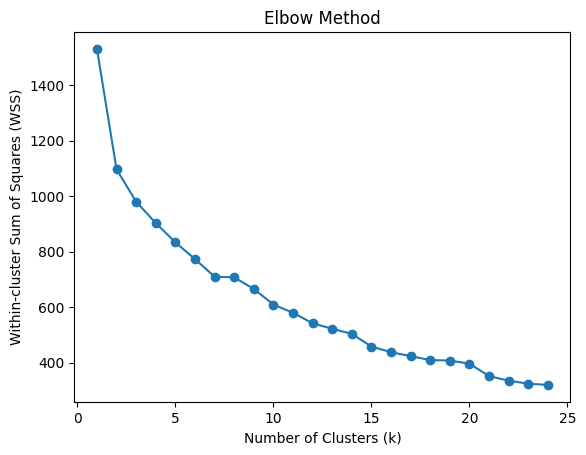

In [182]:
wss = []
for k in range(1, 25):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_a_scaled)
    wss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 25), wss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WSS)')
plt.show()

Now lets try the silhouette score method

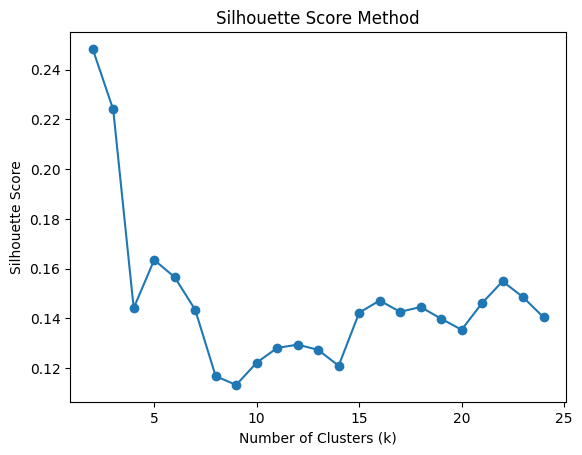

In [183]:
sil_scores = []
for k in range(2, 25):  # Silhouette score is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_a_scaled)
    score = silhouette_score(X_a_scaled, kmeans.labels_)
    sil_scores.append(score)

# Plot the silhouette scores
plt.plot(range(2, 25), sil_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

Based upon the silhouette score and the elbow method, we are going to select 5 as the ideal number of clusters. 

In [ ]:
# Create and fit the KMeans model
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose the number of clusters as needed
df_a['cluster'] = kmeans.fit_predict(X_a_scaled)  # Add cluster labels to df_a

df_a.head()

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,trb_pct,ts_pct,usg_pct,vorp,ws,ws_per_48,total_minutes,pct_gs,usage,cluster
96,2020,Alex Caruso,PG,25,LAL,21,1.0,24.3,2.3,5.4,...,5.6,0.543,13.4,0.2,0.8,0.080,510.3,0.047619,6838.02,1
29,2006,Alonzo Mourning,C,35,MIA,21,0.0,10.8,1.2,1.8,...,16.0,0.721,15.2,0.3,1.0,0.204,226.8,0.000000,3447.36,1
71,2015,Andre Iguodala,SF,31,GSW,21,3.0,30.2,3.9,8.1,...,8.1,0.546,15.1,1.0,2.2,0.170,634.2,0.142857,9576.42,1
72,2015,Andrew Bogut,C,30,GSW,19,18.0,23.2,2.2,3.9,...,19.0,0.551,10.9,0.4,1.4,0.153,440.8,0.947368,4804.72,2
47,2010,Andrew Bynum,C,22,LAL,23,23.0,24.4,3.5,6.5,...,16.4,0.570,15.8,0.3,1.7,0.150,561.2,1.000000,8866.96,2


We have created the clusters using the NBA champions data.

Lets inspect the clusters, and see how they differ.

In [ ]:
def feature_histogram(feature):

    # Set up a figure with subplots: 1 row and 5 columns for 5 clusters
    fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

    # Loop through each cluster (assuming cluster labels are 0, 1, 2, 3, 4)
    for i, cluster in enumerate(range(5)):  # Adjust number of clusters if necessary
        # Select the data for the specific cluster
        cluster_data = df_a[df_a['cluster'] == cluster]
        
        # Plot the histogram for the selected feature in the specific cluster
        axes[i].hist(cluster_data[feature], bins=20, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Cluster {cluster}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
features = [
    "pts_per_g",
    "dbpm",
    'per',
    'ws',
    'usg_pct',
    'ts_pct',
]

for f in features_playoff:
    feature_histogram(f)

In [187]:
def make_simple_count_plot(data):
    plt.figure(figsize=(8, 5))
    sns.countplot(x='cluster', data=data)

    # Add title and labels
    plt.title('Count of Records in Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')

    # Display the plot
    plt.show()

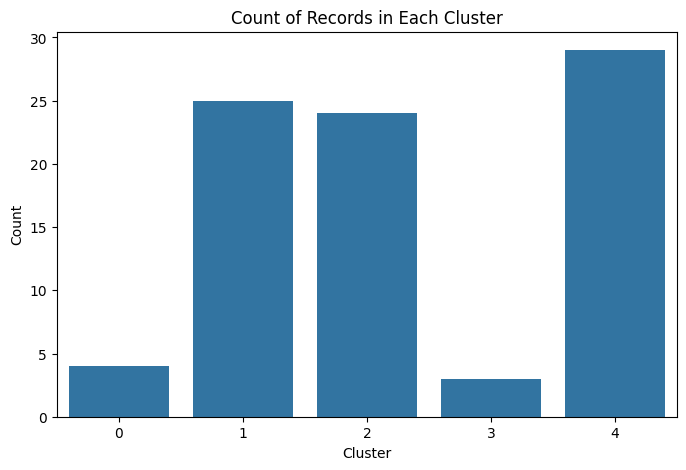

In [188]:
make_simple_count_plot(df_a)

In [189]:
def print_average_plots(average_per_cluster, features_to_plot):

    print(average_per_cluster)

    # Set up the plot
    plt.figure(figsize=(12, 8))

    for feature in features_to_plot:
        plt.figure(figsize=(8, 6))  # Adjust the size of the figure
        plt.plot(average_per_cluster.index, average_per_cluster[feature], marker='o', color='b', label=feature)
        plt.title(f'Average {feature} per Cluster')
        plt.xlabel('Cluster')
        plt.ylabel(f'Average {feature}')
        plt.legend(title=feature)
        plt.tight_layout()  # Adjust layout to prevent overlapping
        plt.show()  # Show the individual plot for each feature

         pts_per_g  fga_per_g  trb_per_g      dbpm      obpm        per  \
cluster                                                                   
0         9.450000   8.575000   2.575000  0.175000  0.225000  13.675000   
1         7.048000   5.492000   3.452000  1.732000 -0.228000  12.428000   
2         9.125000   7.141667   6.866667  1.445833  0.279167  15.295833   
3        18.433333  12.233333   3.500000  1.566667  3.966667  21.300000   
4         4.744828   4.117241   2.072414  0.527586 -1.920690  10.451724   

               ws       ows    usg_pct    ts_pct    pct_gs       dws  \
cluster                                                                
0        1.300000  0.575000  20.225000  0.499750  0.785714  0.725000   
1        1.304000  0.648000  13.292000  0.588640  0.338321  0.672000   
2        1.920833  0.933333  15.554167  0.560583  0.791049  0.991667   
3        2.900000  2.166667  24.933333  0.636667  0.293149  0.733333   
4        0.551724  0.186207  16.606897  0.

<Figure size 1200x800 with 0 Axes>

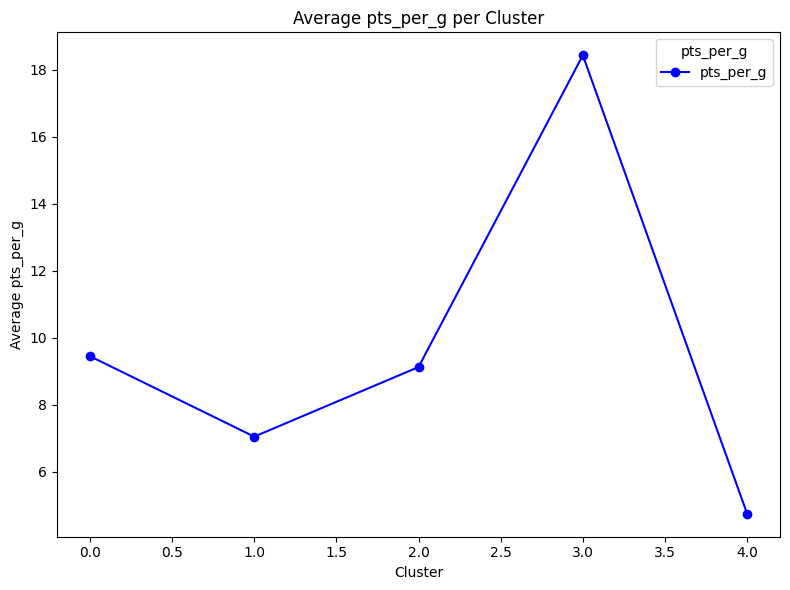

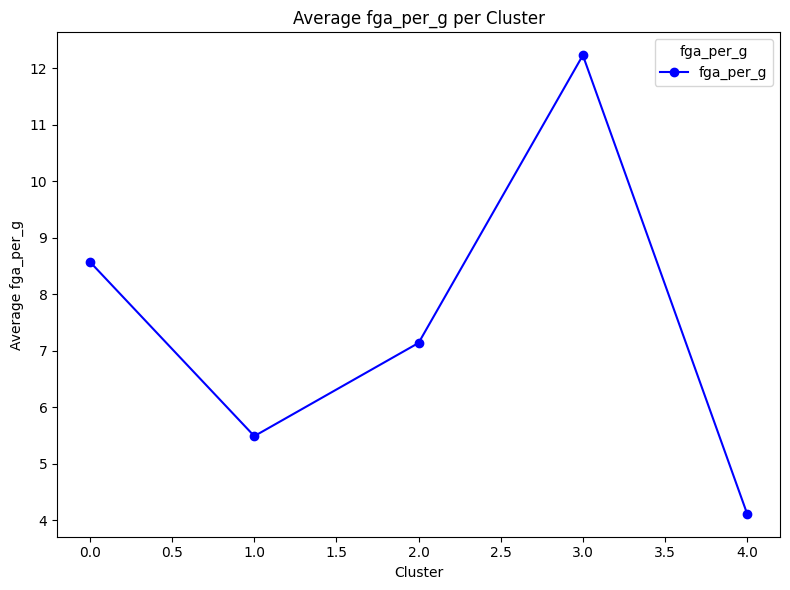

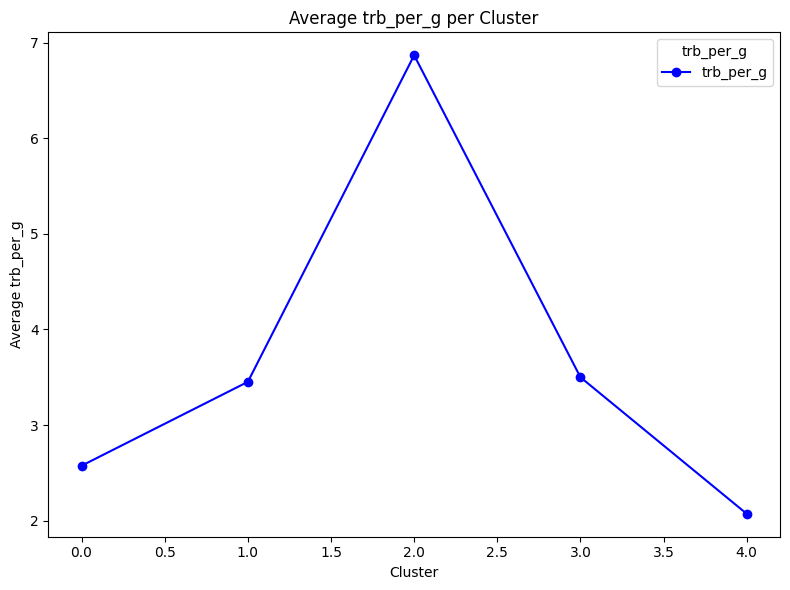

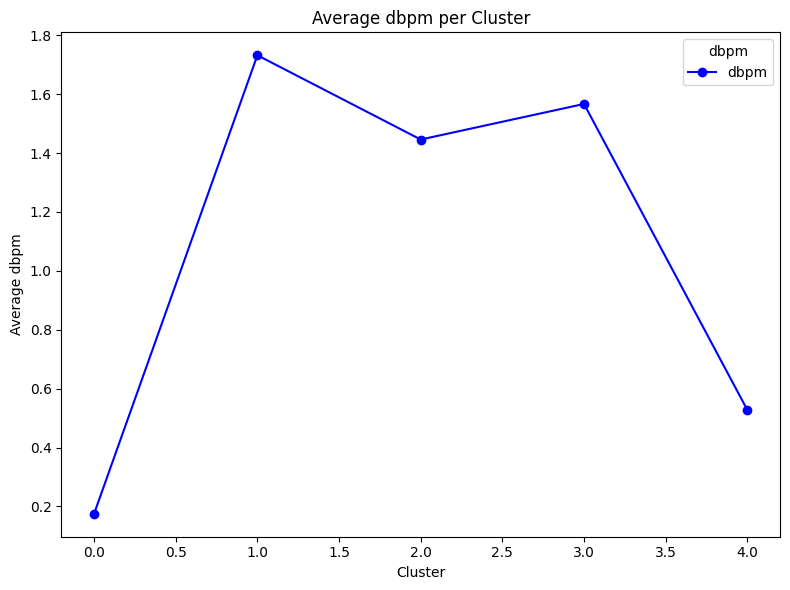

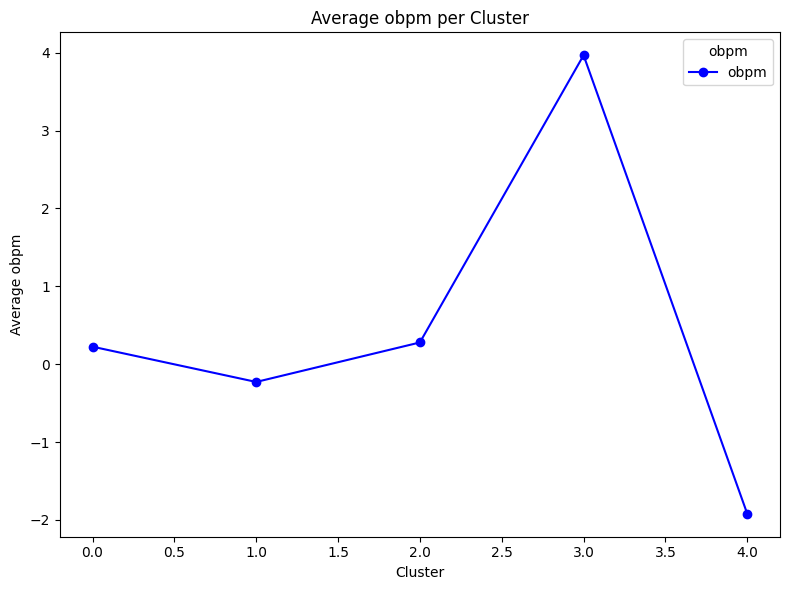

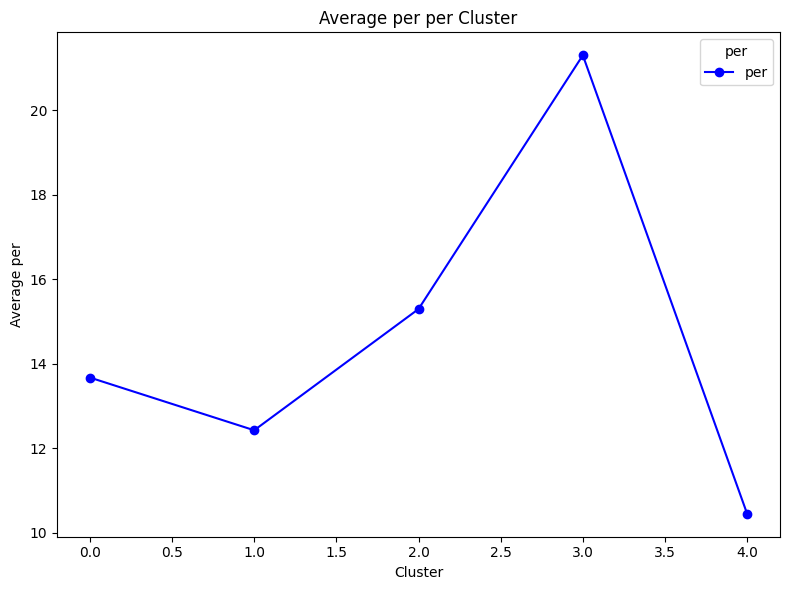

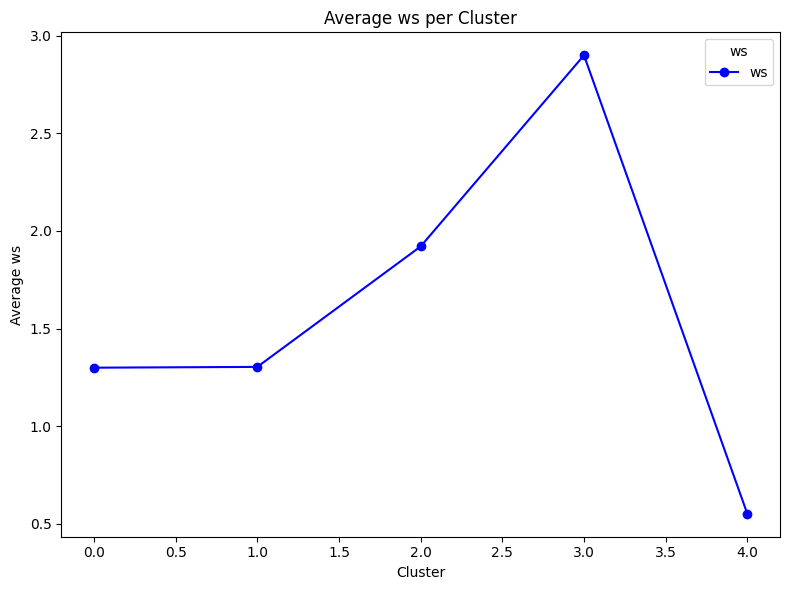

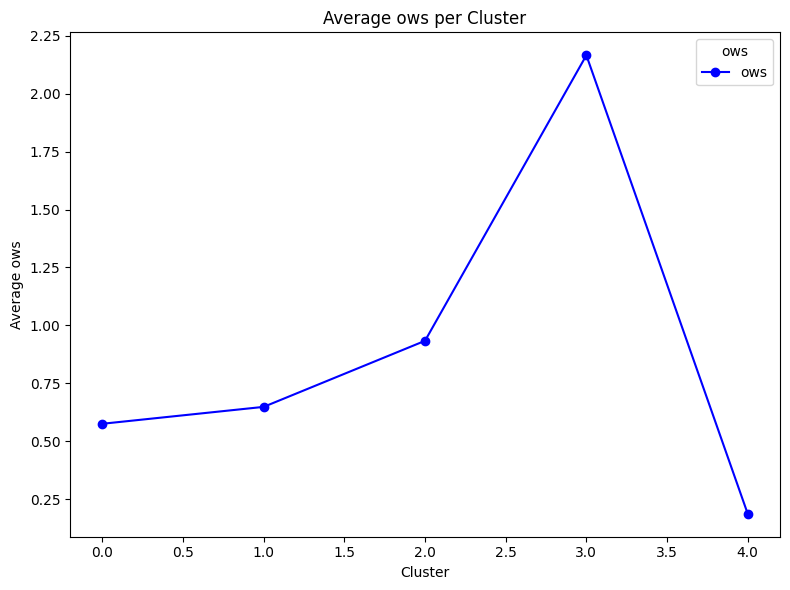

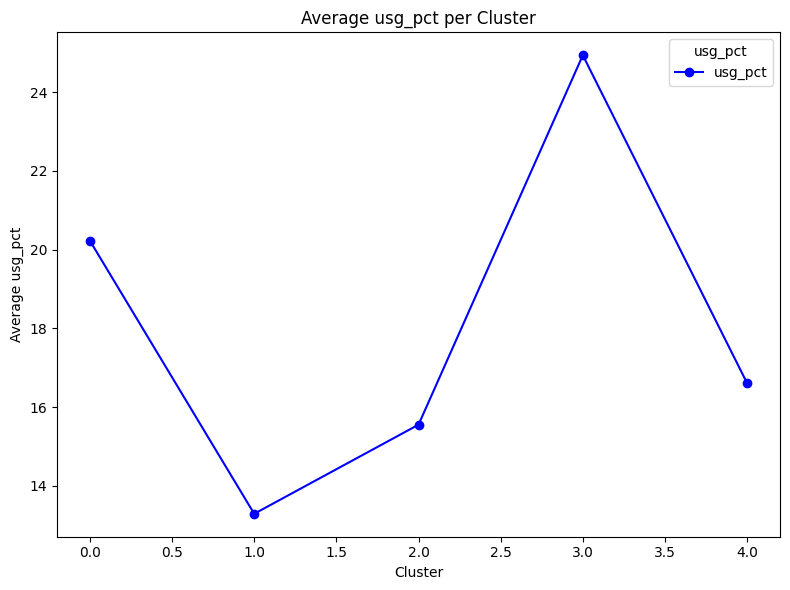

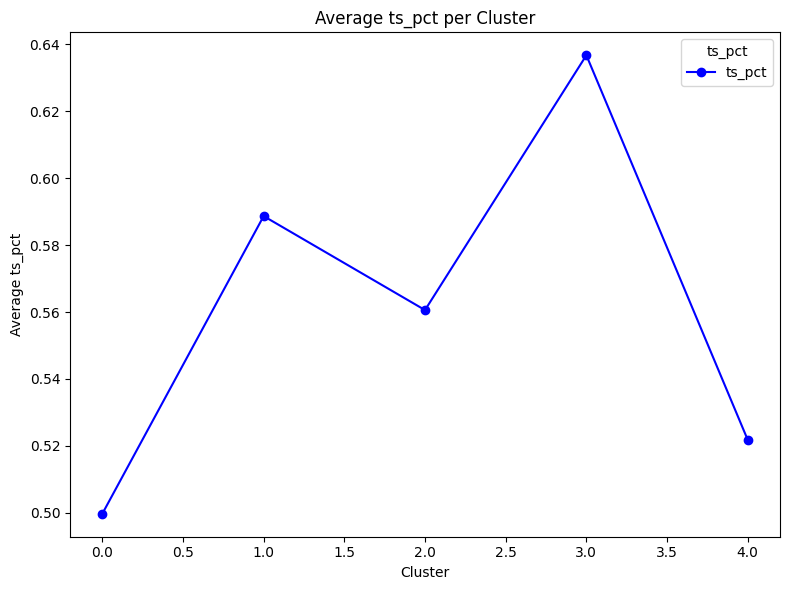

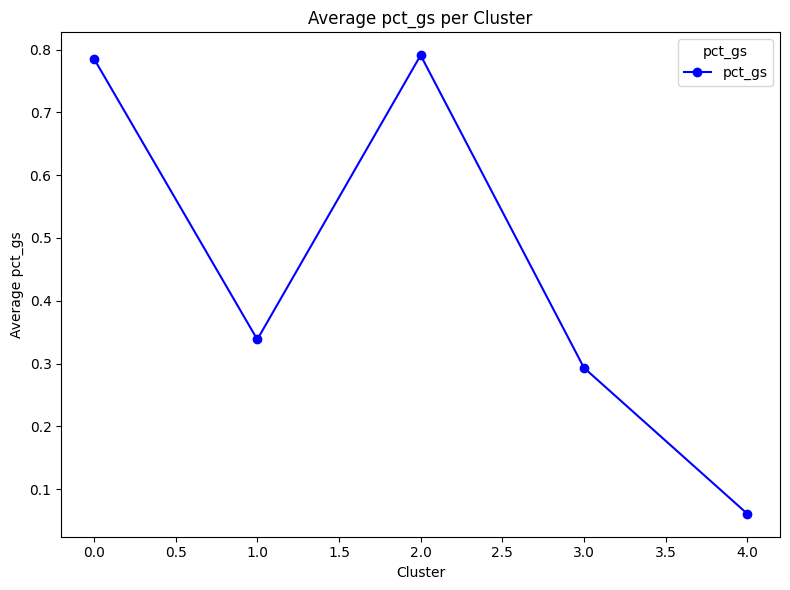

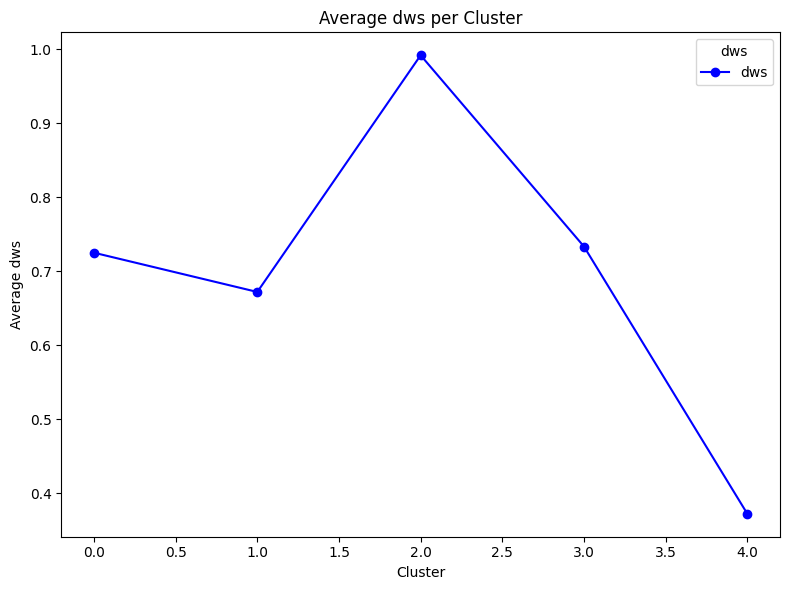

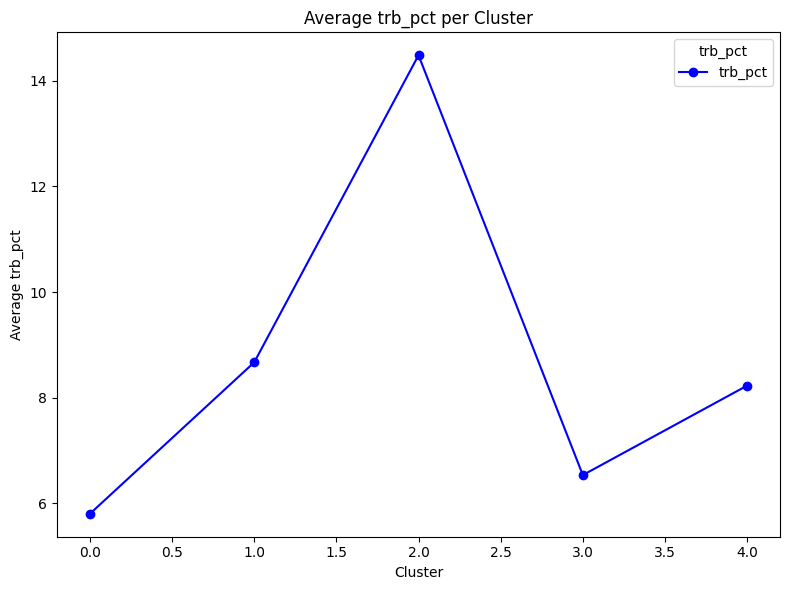

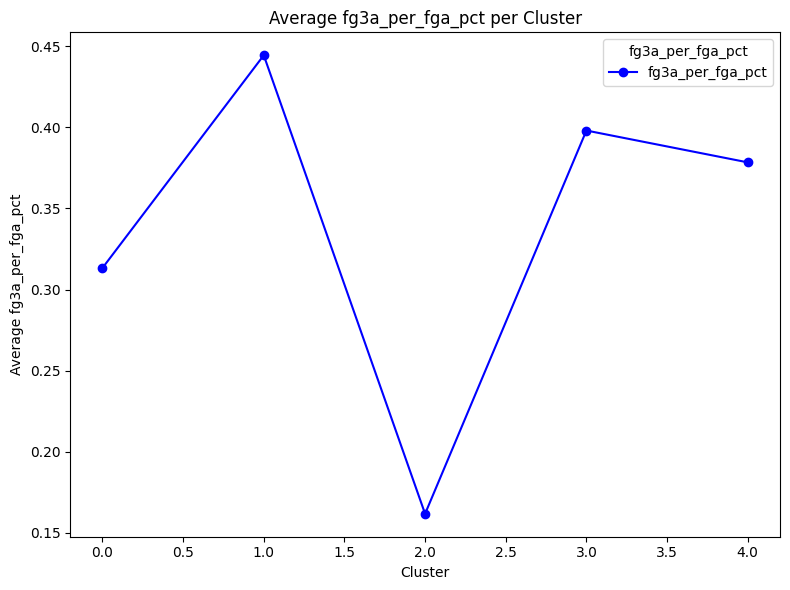

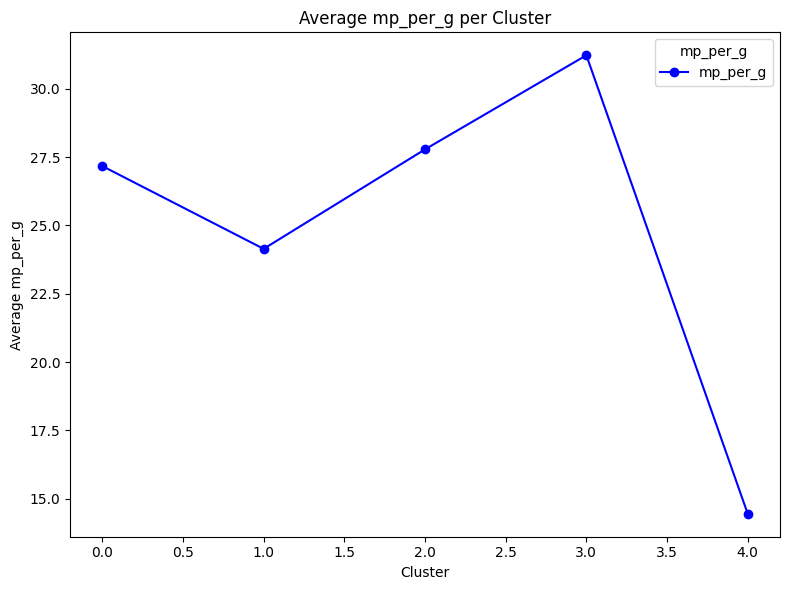

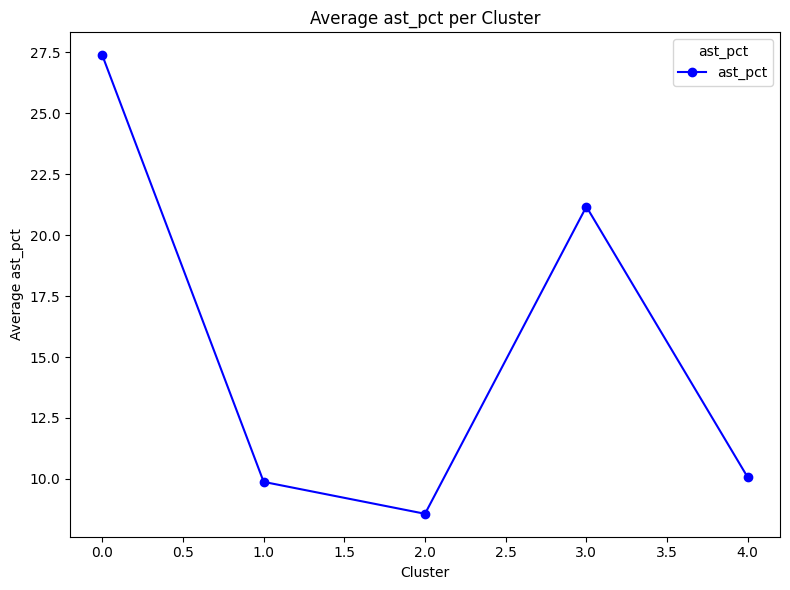

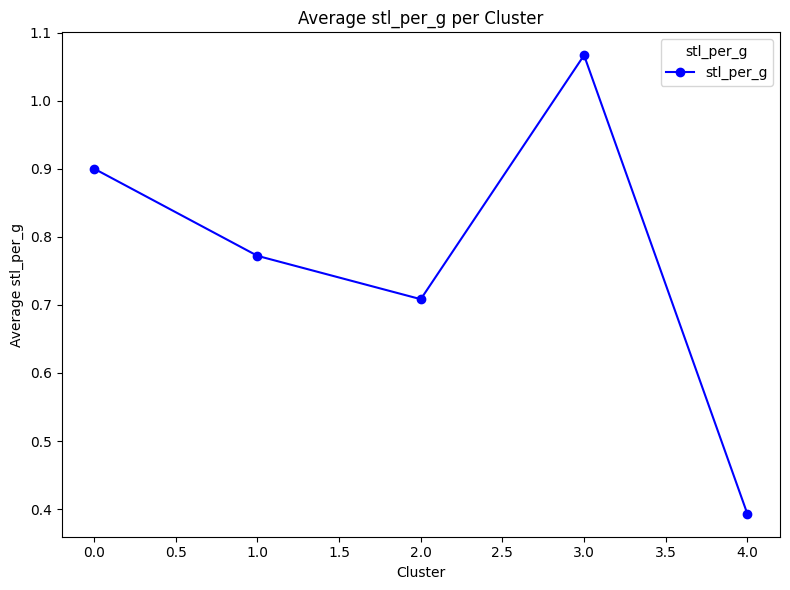

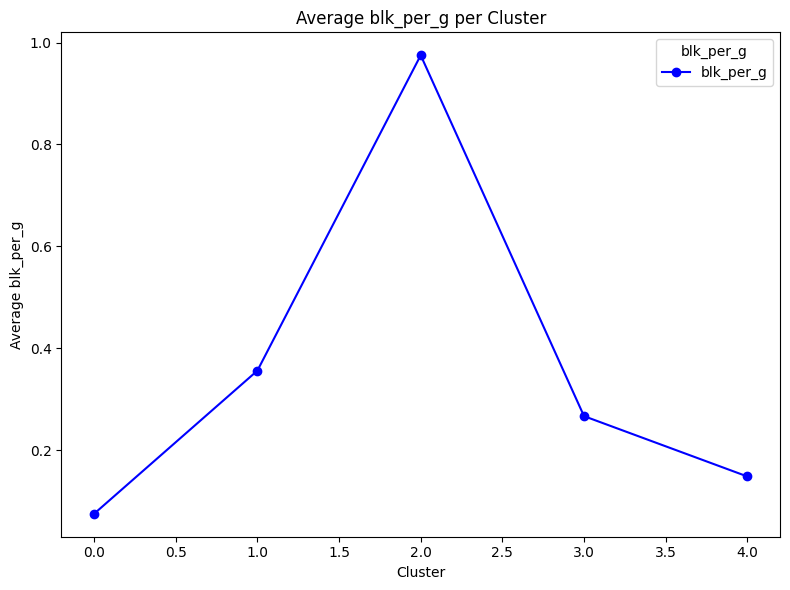

In [190]:
average_per_cluster_a = df_a.groupby('cluster')[features_playoff].mean()

print_average_plots(average_per_cluster_a, features_playoff)

In [191]:
# Print the rows for each cluster
def print_clusters(clustered_data):
    for cluster, group in clustered_data:
        print(f"\nEntries for Cluster {cluster}:")
        print(group[['player', 'season']])  # Adjust the features you want to display
        print("="*50)  # Divider between clusters

In [192]:
clustered_data_a = df_a.groupby('cluster')

print_clusters(clustered_data_a)


Entries for Cluster 0:
            player season
52      J.J. Barea   2011
25  Jason Williams   2006
60  Mario Chalmers   2013
35     Rajon Rondo   2008

Entries for Cluster 1:
                player season
96         Alex Caruso   2020
29     Alonzo Mourning   2006
71      Andre Iguodala   2015
103       Bobby Portis   2021
65          Boris Diaw   2014
22         Brent Barry   2005
10         Bruce Bowen   2003
91         Danny Green   2019
82          David West   2017
45        Derek Fisher   2010
32     Fabricio Oberto   2007
92       Fred VanVleet   2019
28         Gary Payton   2006
109     Gary Payton II   2022
27         James Posey   2006
59        Joel Anthony   2012
31      Michael Finley   2007
62         Norris Cole   2013
108    Otto Porter Jr.   2022
100        P.J. Tucker   2021
102    Pat Connaughton   2021
61           Ray Allen   2013
77   Richard Jefferson   2016
5             Rick Fox   2002
55       Shane Battier   2012

Entries for Cluster 2:
               pla

Now we will add the clusters for records that have been clustered back into the dataframe.

In [193]:
seasons_df['season'] = pd.to_numeric(seasons_df['season'], errors='coerce')  # This will convert to NaN for invalid strings

# Step 2: For each player in df_a that is not in df_b, select the row with the smallest season in seasons_df
players_in_a_not_in_b = df_a[(df_a['cluster'] == 0) & (~df_a['player'].isin(df_b['player']))]

# Step 3: Filter seasons_df to get the rows where 'player' matches the players in df_a
matching_rows_from_c = seasons_df[seasons_df['player'].isin(players_in_a_not_in_b['player'])]

# Step 4: Group by 'player' and get the row with the smallest 'season' for each player
smallest_season_rows = matching_rows_from_c.loc[matching_rows_from_c.groupby('player')['season'].idxmin()]

print(smallest_season_rows)

# Step 5: Append these rows to df_b
df_b_updated = pd.concat([df_b, smallest_season_rows], ignore_index=True)

print(df_b_updated.shape)

df_b = df_b_updated

df_b_shared = df_b.merge(df_a[['player', 'cluster']], on='player', how='inner')

# Merge the shared records back into df_b, so they get assigned the correct cluster
df_b = df_b.merge(df_b_shared[['player', 'cluster']], on='player', how='left')

print(df_b.shape)

      Unnamed: 0          player team_abbreviation   age  player_height  \
4721        4721      J.J. Barea               DAL  23.0         182.88   
1239        1239  Jason Williams               SAC  23.0         185.42   
5637        5637  Mario Chalmers               MIA  23.0         185.42   
4563        4563     Rajon Rondo               BOS  21.0         185.42   

      player_weight       college      country draft_year draft_round  ...  \
4721      79.378600  Northeastern  Puerto Rico  Undrafted   Undrafted  ...   
1239      86.182480       Florida          USA       1998           1  ...   
5637      86.182480        Kansas          USA       2008           2  ...   
4563      77.564232      Kentucky          USA       2006           1  ...   

       pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
4721   2.4  0.8  0.7        -5.7     0.041     0.115    0.250   0.440   
1239  12.8  3.1  6.0        -1.4     0.008     0.080    0.186   0.483   
5637  10.0  2.

We now have a dataframe where some records have clusters, but most do not.

We will use similarity scores to assign clusters to the remaining unclustered records.

We will evaluate both KNN and KMeans for this comparison. (I also evaluated using DBSCAN and NMF, but these methods were singnificantly less effective, so I did not include them in my final submission)

First we need to impute missing values, and apply a scaler to all values. 

In [ ]:
X_b1 = df_b[keep]  # Replace with the relevant feature columns

knn_imputer = KNNImputer(n_neighbors=2)


X_b = knn_imputer.fit_transform(X_b1)

X_b = pd.DataFrame(X_b, columns=X_b1.columns)


# Standardize the features
scaler_b = StandardScaler()
X_b_scaled = scaler_b.fit_transform(X_b)
X_b_scaled = np.abs(X_b_scaled)  # Transform negative values to positive

below is a a function that will perform PCA so that we can visualize our clusters

In [195]:
def pca_and_plot(dfb):

    X_b = dfb[keep]  # Make sure to use the same columns that you used for scaling

    X_b = X_b.apply(lambda col: col.fillna(col.mean()), axis=0)

    # Step 1: Standardize the features before PCA (you can also use your scaler if needed)
    X_b_scaled = scaler_b.transform(X_b)

    # Step 2: Apply PCA to reduce the features to 2D
    pca = PCA(n_components=2)
    X_b_pca = pca.fit_transform(X_b_scaled)

    # Step 3: Add PCA components to the DataFrame for plotting
    dfb_pca = pd.DataFrame(X_b_pca, columns=['PCA1', 'PCA2'])
    dfb_pca['cluster'] = dfb['cluster']  # Assign the clusters to the reduced components

    # Step 4: Create the scatter plot
    plt.figure(figsize=(10, 6))

    # Scatter plot, using different colors for each cluster
    sns.scatterplot(data=dfb_pca, x='PCA1', y='PCA2', hue='cluster', palette='Set1', style='cluster', s=100)

    # Step 5: Customize the plot
    plt.title('2D Visualization of Clusters after PCA')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

knn

In [196]:
def knn_model_and_plot(dfb1):
    dfb = dfb1.copy(deep=True)

    X1 = dfb[keep]  # Features for all rows
    Y = dfb['cluster']  # Cluster labels for rows with assigned clusters

    knn_imputer = KNNImputer(n_neighbors=3)

    X = knn_imputer.fit_transform(X1)

    # Separate clustered and unclustered data
    X_clustered = X[dfb['cluster'].notna()]  # Labeled data
    Y_clustered = Y[dfb['cluster'].notna()]  # Labels of clustered data
    X_unclustered = X[dfb['cluster'].isna()]  # Unlabeled data

    # Scale the features (important for KNN)
    scaler = StandardScaler()
    X_clustered_scaled = scaler.fit_transform(X_clustered)
    X_unclustered_scaled = scaler.transform(X_unclustered)
    X_scaled = scaler.transform(X)

    # Train a KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5)  # You can tune the number of neighbors
    knn.fit(X_clustered_scaled, Y_clustered)

    # Predict clusters for unclustered data
    predicted_clusters = knn.predict(X_unclustered_scaled)

    # Assign the predicted clusters to the unclustered rows in the original dataframe
    dfb.loc[dfb['cluster'].isna(), 'cluster'] = predicted_clusters

    # Silhouette Score (more meaningful for clustering tasks, but can still be computed here)
    silhouette = silhouette_score(X_scaled, dfb['cluster'])
    print("Silhouette Score (KNN):", silhouette)

    # Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(X_scaled, dfb['cluster'])
    print("Davies-Bouldin Index (KNN):", davies_bouldin)
    pca_and_plot(dfb)
    return dfb

# Now df will have clusters assigned to the unclustered data as well

k means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def kmeans_model_and_plot(dfb1):
    dfb = dfb1.copy(deep=True)


    X1 = dfb[keep]  # Features for all rows


    X_b_additional = dfb[dfb['cluster'].isna()][keep]  # Features for unclustered records
    X_b_clustered = dfb[dfb['cluster'].notna()][keep]  # Features for clustered records

    X_b_additional = X_b_additional.apply(lambda col: col.fillna(col.mean()), axis=0)
    X_b_clustered = X_b_clustered.apply(lambda col: col.fillna(col.mean()), axis=0)
    X1 = X1.apply(lambda col: col.fillna(col.mean()), axis=0)
    

    # Standardize the features of unclustered and clustered records
    X_b_additional_scaled = scaler_b.transform(X_b_additional)
    X_b_clustered_scaled = scaler_b.transform(X_b_clustered)
    X_scaled = scaler_b.transform(X1)
    # X_scaled = scaler.transform(X1)

    # Calculate the cosine similarity between unclustered records and clustered records
    similarity_matrix = cosine_similarity(X_b_additional_scaled, X_b_clustered_scaled)

    # Find the most similar clustered record for each unclustered record
    closest_matches = np.argmax(similarity_matrix, axis=1)

    # Ensure that closest_matches has the same length as the number of unclustered records
    print("Shape of closest matches:", closest_matches.shape)  # Check the shape
    print("Shape of unclustered records:", X_b_additional.shape)

    # Get the cluster labels of the most similar clustered records
    closest_clusters = dfb.loc[dfb['cluster'].notna(), 'cluster'].iloc[closest_matches].values

    # Assign the closest cluster to the unclustered records in dfb
    dfb.loc[dfb['cluster'].isna(), 'cluster'] = closest_clusters

    # Print the updated dfb to check if all unclustered records got assigned a cluster
    # print(dfb)

    silhouette = silhouette_score(X_scaled, dfb["cluster"])
    print("Silhouette Score (KMeans):", silhouette)

    # Calculate the Davies-Bouldin Index_scaled
    davies_bouldin = davies_bouldin_score(X_scaled, dfb["cluster"])
    print("Davies-Bouldin Index (KMeans):", davies_bouldin)

    # Calculate Inertia (within-cluster sum of squares)
    inertia = kmeans.inertia_
    print("Inertia (KMeans):", inertia)

    # Print the updated df_b to check if all unclustered records got assigned a cluster

    pca_and_plot(dfb)

    return (dfb, similarity_matrix)

    

    # Now df will have clusters assigned to the unclustered data as well

Shape of closest matches: (652,)
Shape of unclustered records: (652, 19)
Silhouette Score (KMeans): -0.030876841609776003
Davies-Bouldin Index (KMeans): 4.83466823453441
Inertia (KMeans): 833.4304121968271


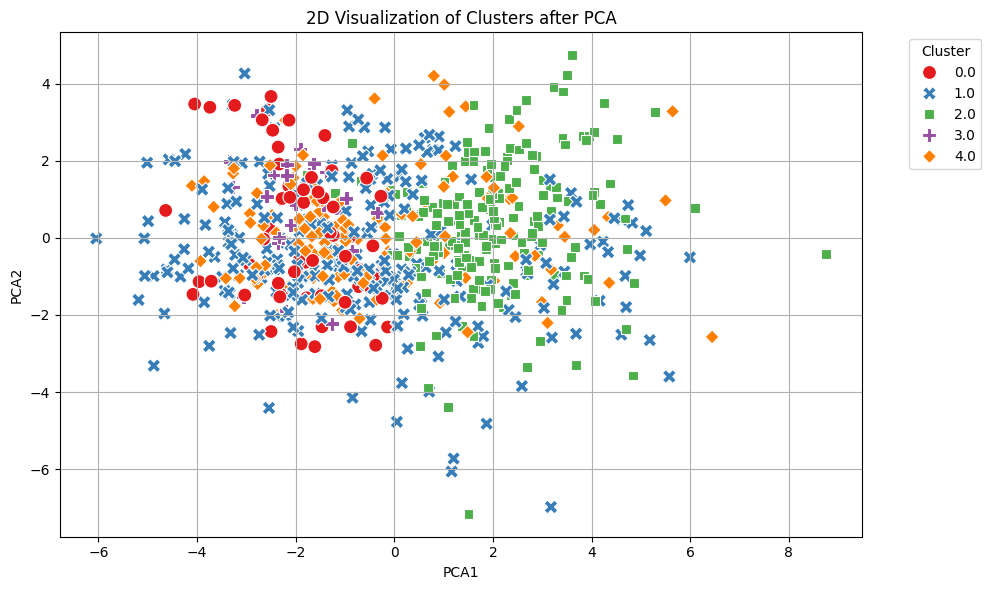

Silhouette Score (KNN): -0.12024941660514259
Davies-Bouldin Index (KNN): 3.487489016385081


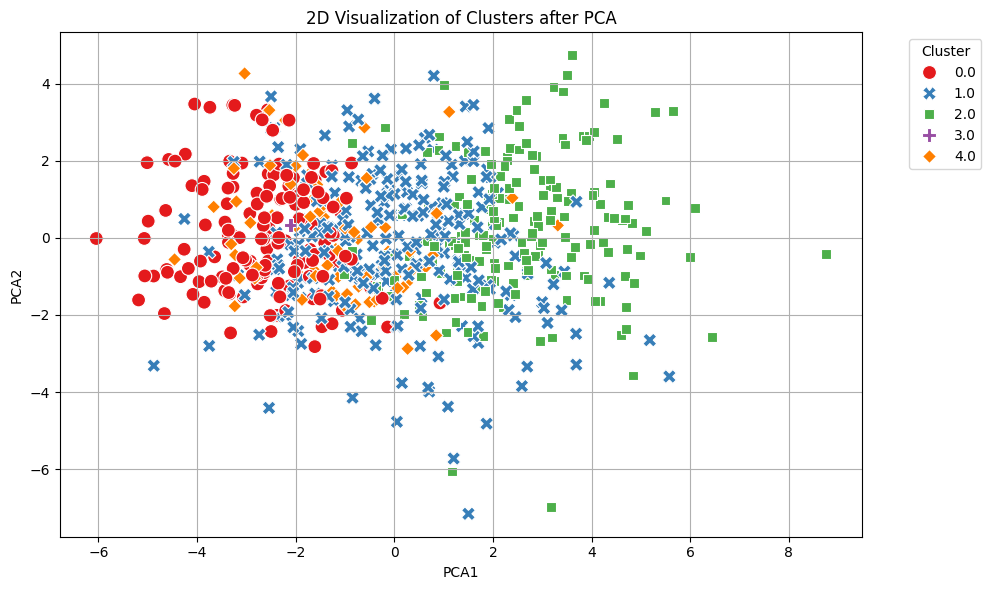

In [198]:
(df_kmeans, sm) = kmeans_model_and_plot(df_b)
df_knn = knn_model_and_plot(df_b)

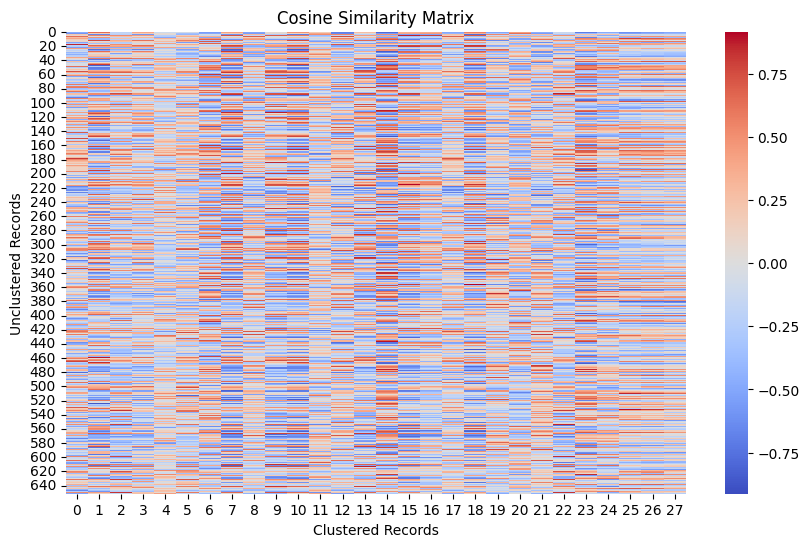

In [199]:
plt.figure(figsize=(10, 6))
sns.heatmap(sm, cmap='coolwarm', annot=False)
plt.title('Cosine Similarity Matrix')
plt.xlabel('Clustered Records')
plt.ylabel('Unclustered Records')
plt.show()

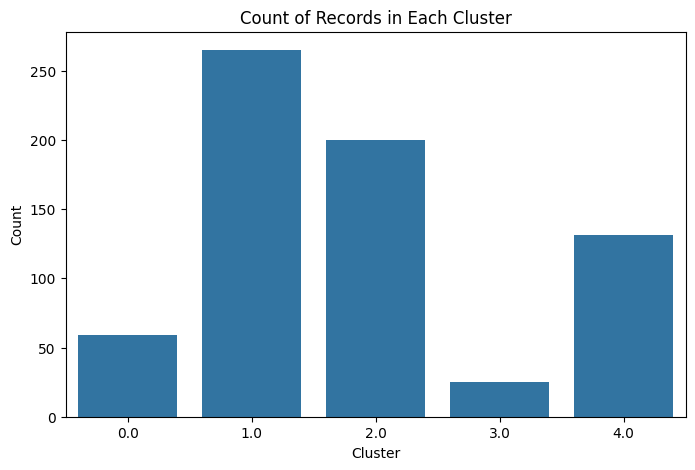

In [200]:
make_simple_count_plot(df_kmeans)
# make_simple_count_plot(df_knn)

         player_height  player_weight   wingspan  standing_reach  \
cluster                                                            
0.0         191.490169      87.174232  79.913265       99.744898   
1.0         197.113585      95.392965  81.394636      102.114943   
2.0         206.603600     106.480722  85.739796      107.607692   
3.0         191.719200      88.740739  78.250000       99.160000   
4.0         198.488397      96.971737  81.507937      102.321429   

         body_fat_pct  standing_vertical_leap  max_vertical_leap  \
cluster                                                            
0.0          6.117045               29.621622          35.432432   
1.0          6.408462               29.836777          35.732365   
2.0          7.771778               29.365625          34.115625   
3.0          6.885714               28.071429          33.714286   
4.0          7.721864               29.776549          35.451327   

         lane_agility_time  three_quarter_spri

<Figure size 1200x800 with 0 Axes>

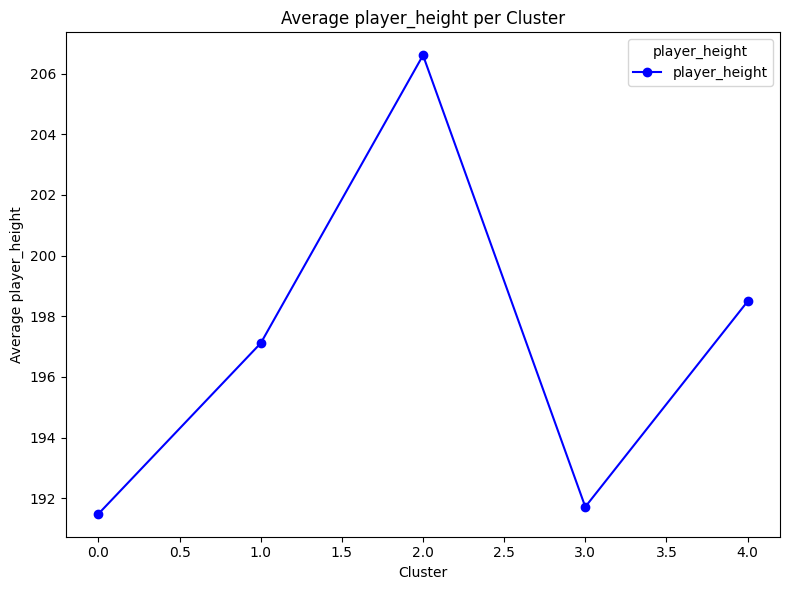

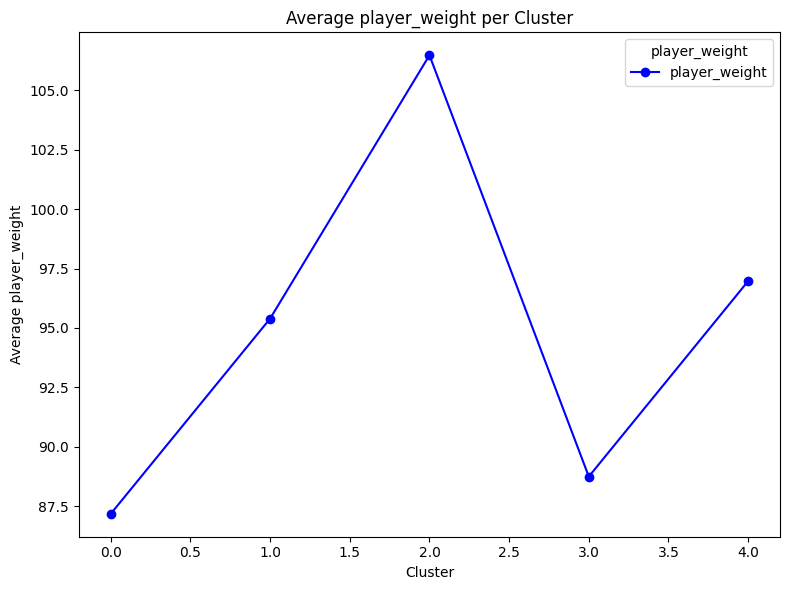

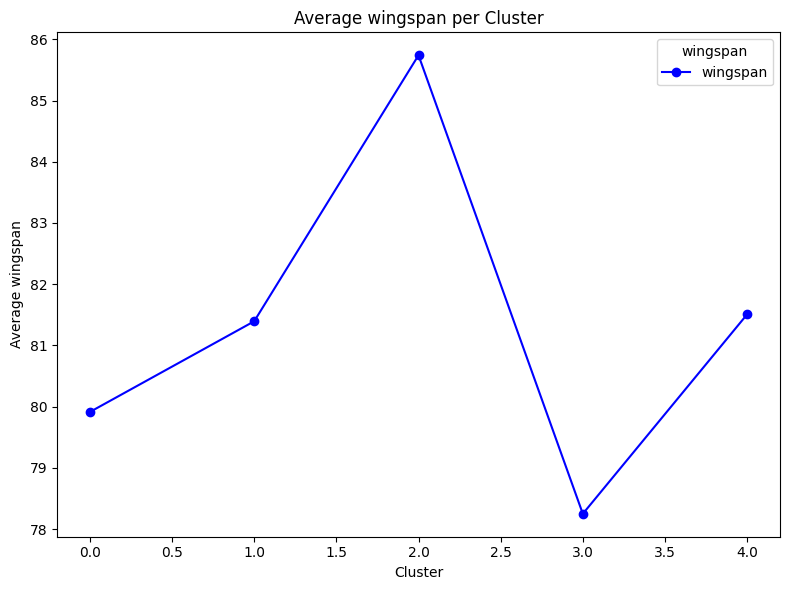

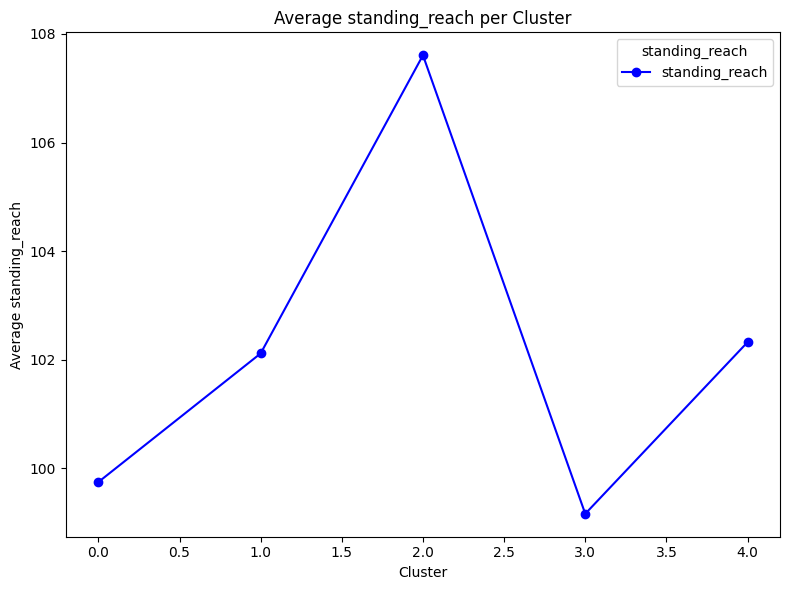

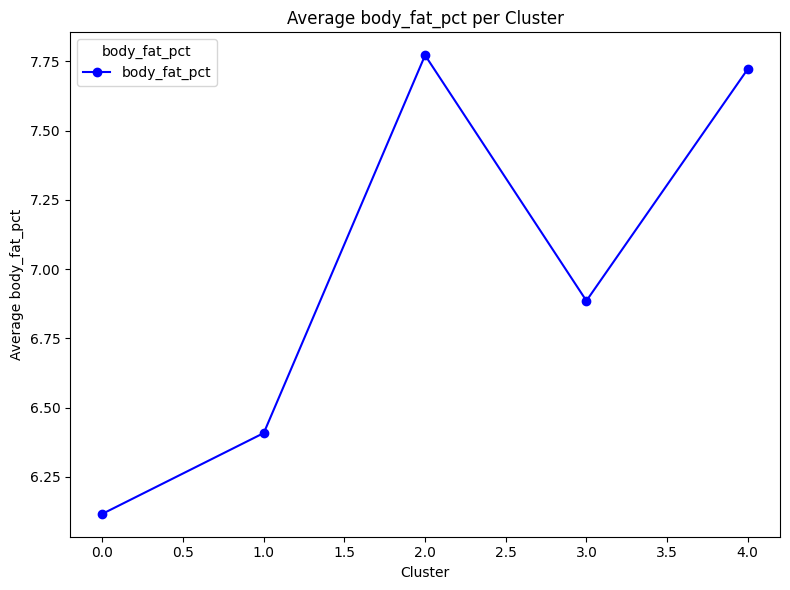

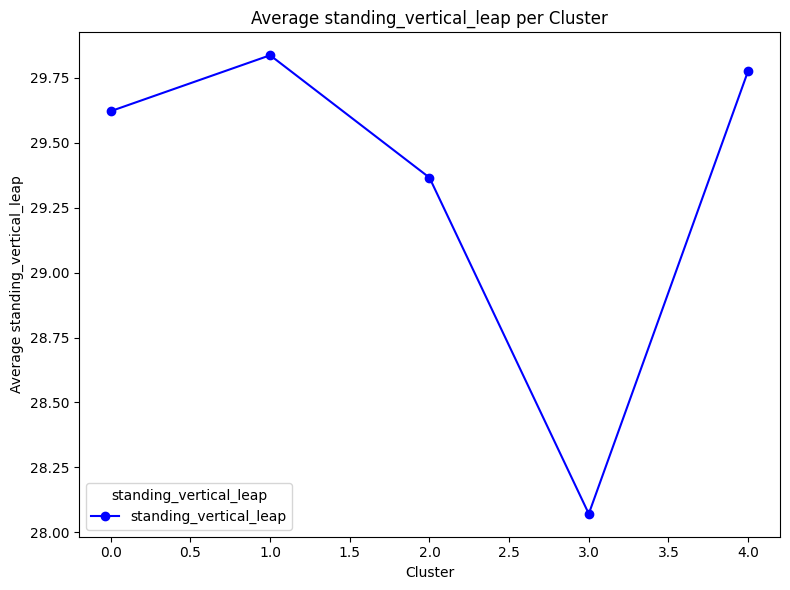

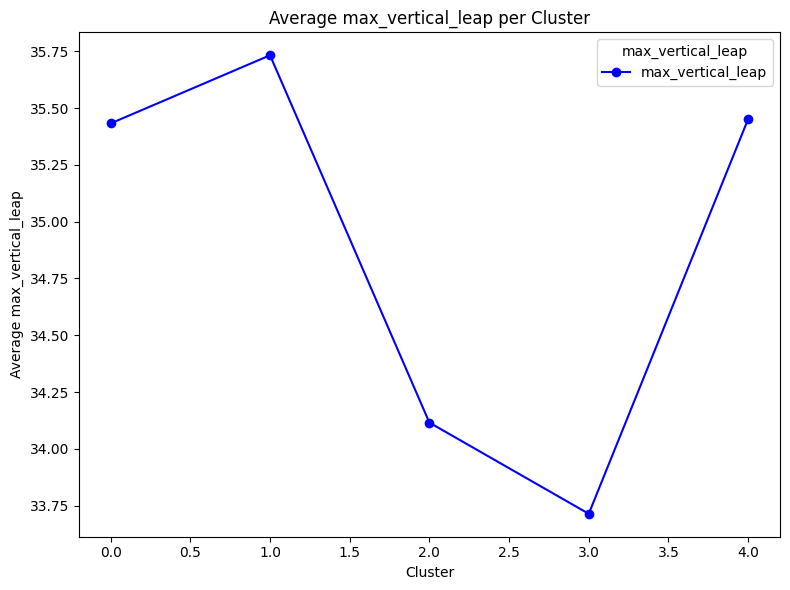

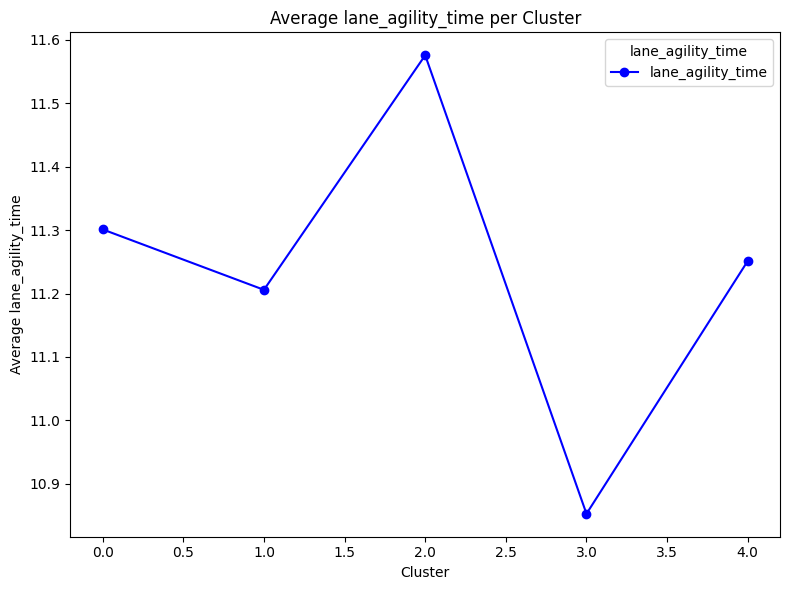

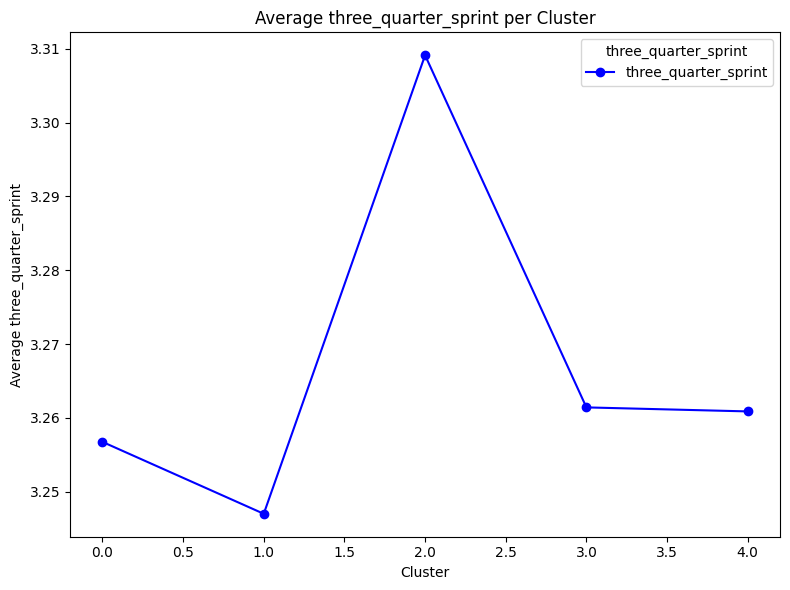

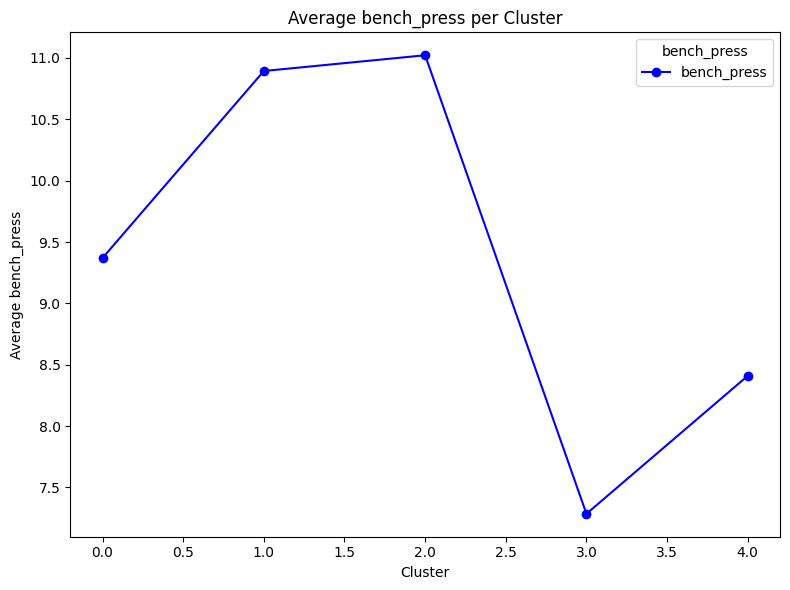

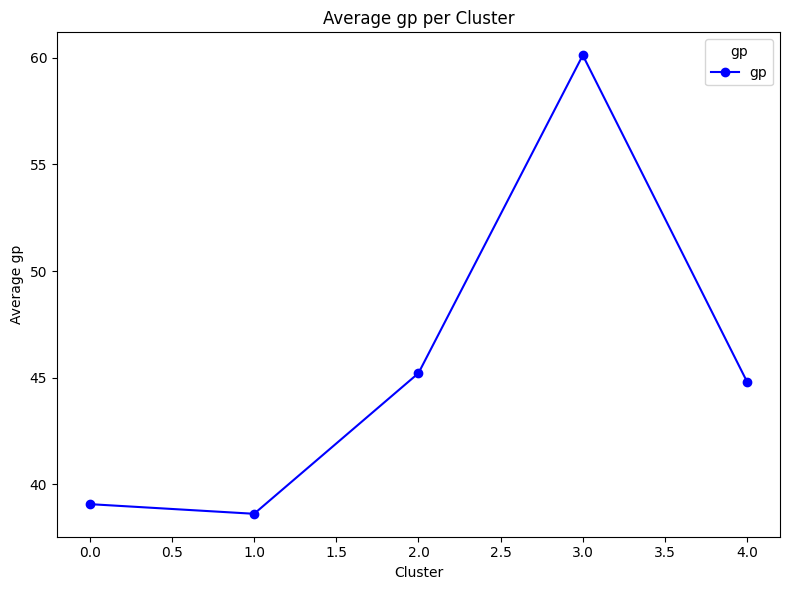

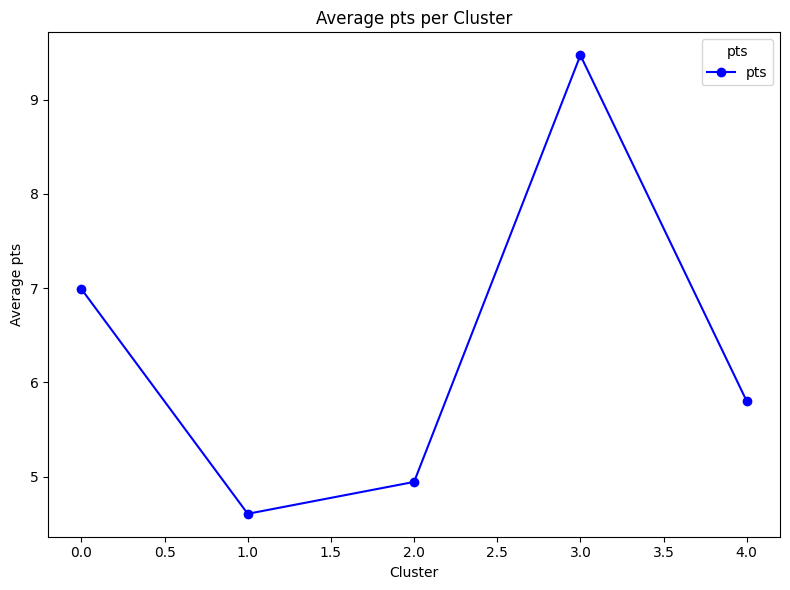

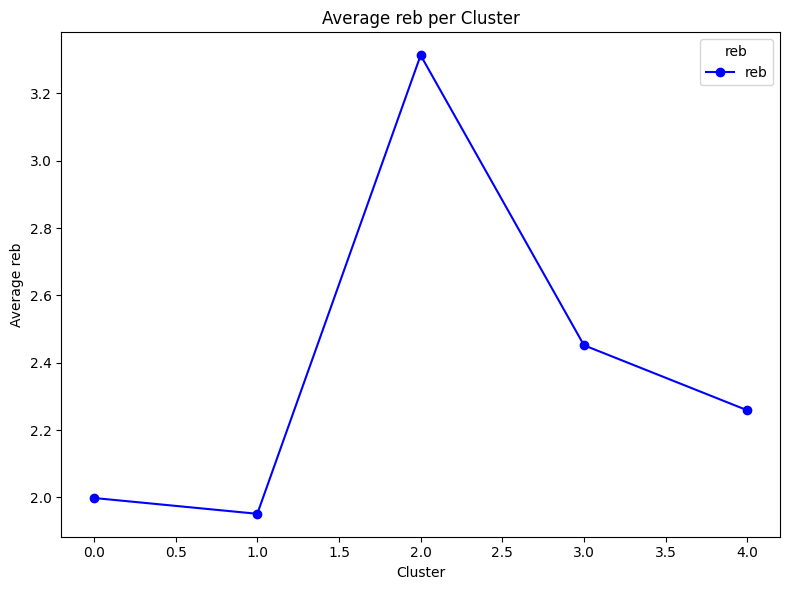

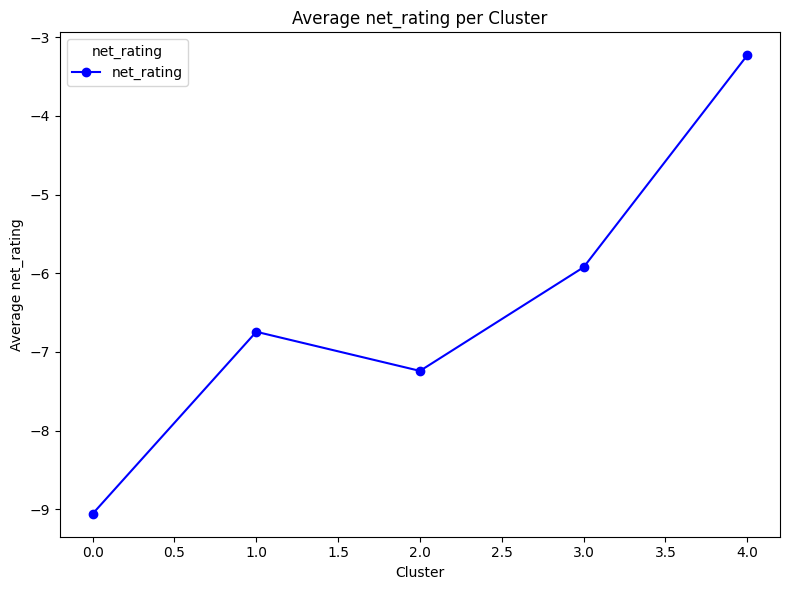

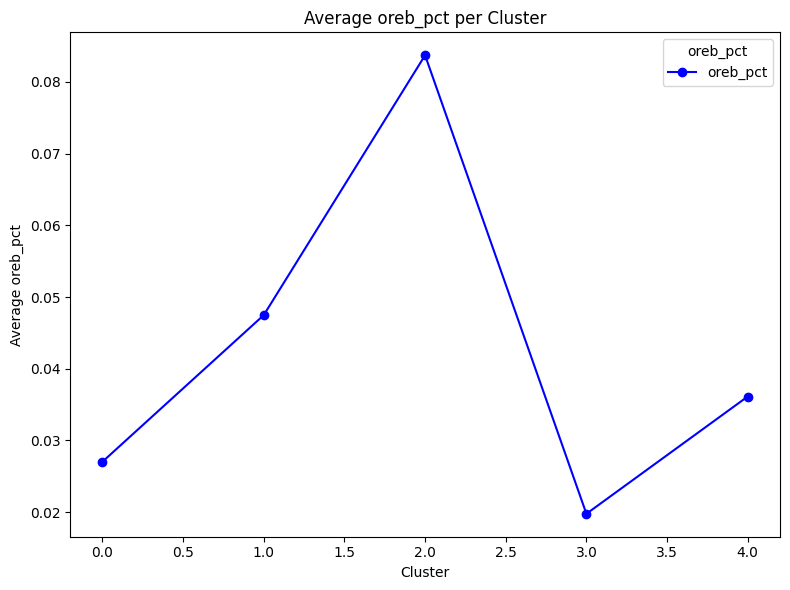

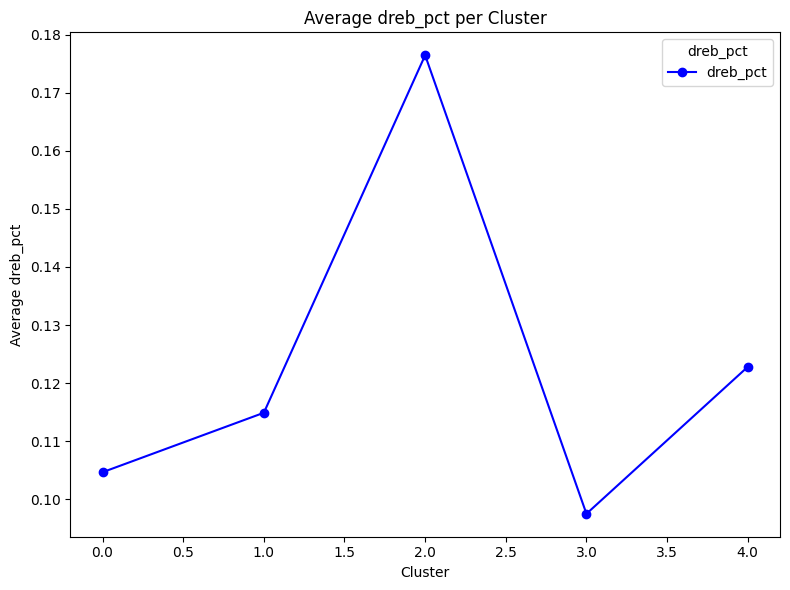

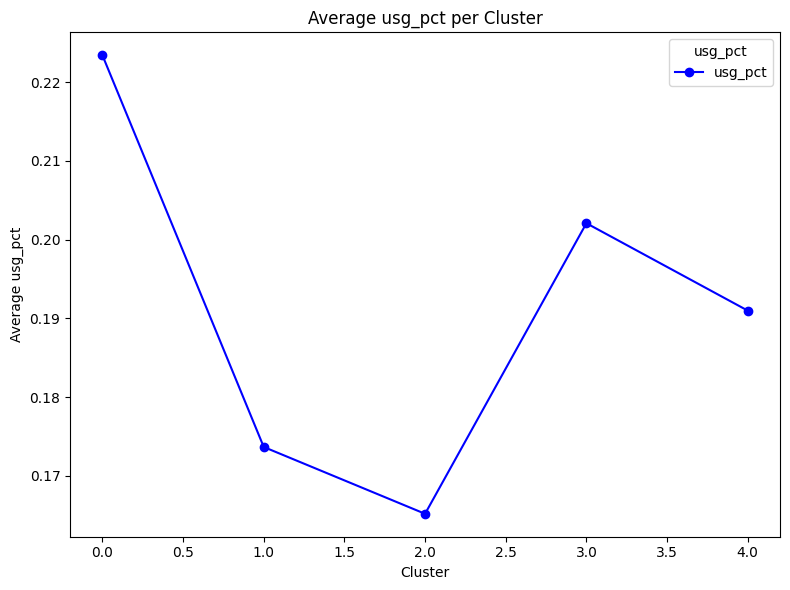

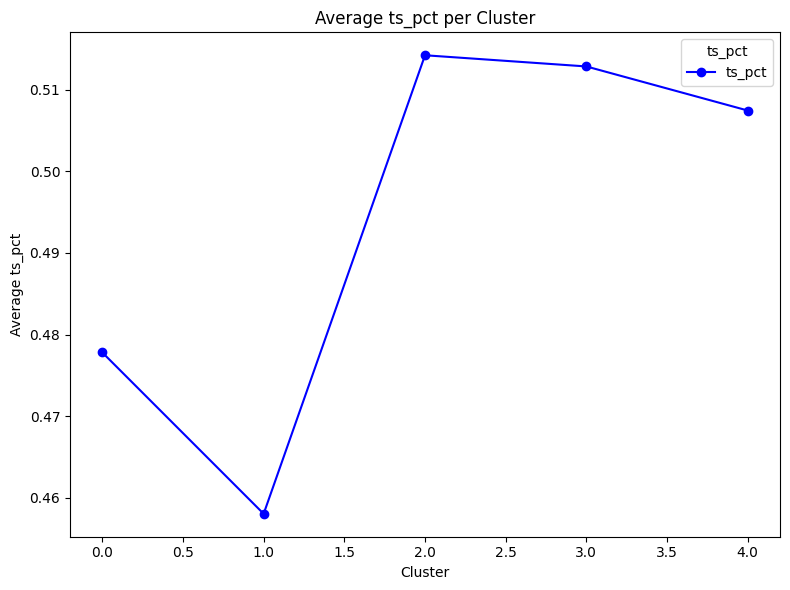

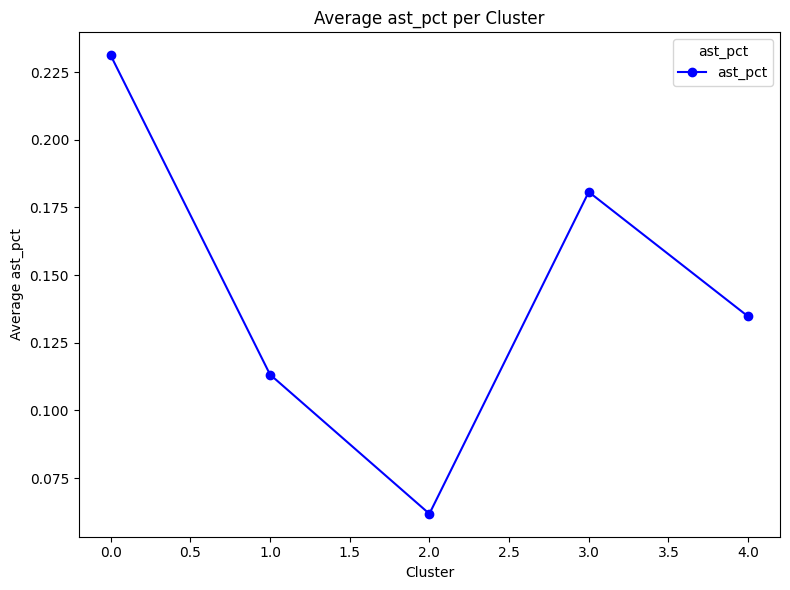

In [201]:
average_per_cluster_kmeans = df_kmeans.groupby('cluster')[keep].mean()
average_per_cluster_knn = df_knn.groupby('cluster')[keep].mean()

print_average_plots(average_per_cluster_kmeans, keep)



In [202]:
new_players = [
    "Michael Porter Jr.",
    "Aaron Gordon",
    "Kentavious Caldwell-Pope",
    "Bruce Brown",
    "Jeff Green",
    "DeAndre Jordan",
    "Christian Braun",

    "Jaylen Brown",
    "Kristaps Porziņģis",
    "Derrick White",
    "Al Horford",
    "Sam Hauser",
    "Payton Pritchard",
]

In [ ]:
def find_player_cluster(player_name):
    # Search for the player
    player_row = df_kmeans[df_kmeans['player'].str.contains(player_name, case=False, na=False)]
    
    if not player_row.empty:
        # If the player is found, print the cluster
        cluster = player_row['cluster'].values[0]
        print(f"The player {player_name} is in cluster {cluster}.")
    else:
        print(f"Player {player_name} not found.")


for p in new_players:
    find_player_cluster(p)

clustered_data_b = df_kmeans.groupby('cluster')

Player Michael Porter Jr. not found.
The player Aaron Gordon is in cluster 2.0.
The player Kentavious Caldwell-Pope is in cluster 1.0.
The player Bruce Brown is in cluster 4.0.
The player Jeff Green is in cluster 1.0.
The player DeAndre Jordan is in cluster 2.0.
The player Christian Braun is in cluster 4.0.
Player Jaylen Brown not found.
Player Kristaps Porziņģis not found.
The player Derrick White is in cluster 4.0.
The player Al Horford is in cluster 2.0.
Player Sam Hauser not found.
Player Payton Pritchard not found.

Entries for Cluster 0.0:
                       player season
12             Gilbert Arenas   2001
25               Joseph Forte   2001
27               Jeryl Sasser   2001
29          Brandon Armstrong   2001
41               Luke Jackson   2004
42                Luis Flores   2004
90             Rawle Marshall   2005
93              Bracey Wright   2005
96                 Alex Acker   2005
106                Chris Paul   2005
125                 Coby Karl   2007
145 

# Analysis of clusters.

### Cluster 0:
The shortest and lightest cluster, but a significant margin. Noticeable higher usage rate.
This cluster is a ball handler, and a playmaker, as evident by their higher usage rates, assist volume and assist percentage. This player typically starts in the playoffs, as the mean games started per game played is 0.8. I would hypothesize that this cluster represents a “point guard” that is a little overqualified for their offensive role.

### Cluster 1
This cluster appears to represent players that are impactful on the defensive side of the game. The cluster is the highest is defensive box plus minus, and a net negative in offensive box plus minus. The cluster has a low usage percentage, but a high shooting percentage and a high ratio of three pointers shot – over 44% of this cluster’s shot attempts are three pointers. This cluster also typically comes off the bench, with a mean games started of 33.8%. Looking at the draft combines measurables for this cluster, including the predicted values. This is the most athletic cluster, if you consider all variables. This cluster represents a defensively-oriented player that is not particularly involved on offense.

### Cluster 2:
This cluster is a starting big man that is not a featured offensive player. This cluster is off the charts in blocks and rebounds, and extremely high in win shares, and first in defensive win shares. This is also one of the more common clusters, with over 1 per team. Due to its commonality, and high impact on winning, I would hypothesize that this is one of the more valuable clusters. This cluster is the largest, and tallest cluster. 

### Cluster 3:
This cluster is very interesting. It represents a player that is highly impactful offensively off the bench. The classic example of this would be Manu Ginobili from those classic Spurs teams. This cluster scores off the charts in usage percentage, offensive win shares, and shot attempts. It also has the highest minutes per game, while having a very low ‘games started’ number. This cluster signifies a player that is your “6th man” in name, but is likely closer to the team's third best offensive option. 

### Cluster 4:
This is the most common and least impactful cluster. This cluster is off the charts negative in offensive box plus minus, and offensive win shares. However, this cluster represents an above average defensive player. This cluster was last in shooting percentage, and third in usage percentage. This player is last in shot attempts, and last in minutes played per game. Basically, this is a player that comes off of the bench, doesn't mess up on defense, and should probably stay out of the way on offense.


## Reasons why the clusters could be better:
Difference in era. We are looking at 20+ years of data. The way that basketball is played, covered and officiated has changed drastically in this time. The skillset a play may need in 2024 is likely somewhat different than what a player may have needed in 2001.

## Lack of emphasis on personal or team style. 
Everyone plays basketball a little differently. Certain aspects of the game cannot be represented in simple statistical models. It is probable that the entirety of a player's impact is not fully being represented by the statistics used in this model.

## Ways to improve the model:
I have a couple ideas of ways to improve the model. The first is providing more context to the features. One could consider the type of star offensive player these clustered role players are supporting. For example, someone playing with Steph Curry likely needs a different skillset than someone playing alongside Shaquille ONeal. We could also consider team play style. We could cluster teams based upon statistical analysis, making groups according to play style. It could be possible that teams that play a similar pace, scoring spread and efficiency may have players of a similar mold. 
